In this section of the code, we train 4 discrete Machine and Deep learning models with the purpose of forecasting traffic flow along every path within the time series dataset. Consequently, we conduct a meticulous analysis of the vehicular flux within the city of San Francisco for each pathway, under the guidance and enforcement of the SQP rules.

<b>The SPQ rules are fully described here:</b>https://dl.acm.org/doi/abs/10.1145/2666310.2666413

### Phase 4: Preprocess the time series dataset and add weather data on it
In this step, the following commands are executed:
- Load time series dataset that created using SPQ function
- Preprocess the time series dataset
- Read weather data and preprocess them
- Aggregate traffic flow data with weather data
- Make visualizations of traffic flow per day and per 3-hour interval
- Extract features that are helpful to our research

In [2]:
!pip install ipython-autotime

# measure execution time
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.1 MB/s eta 0:00:00
time: 297 µs (started: 2023-08-11 10:50:36 +00:00)


In [3]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

# standard library imports
import pandas as pd
import numpy as np

# visualization libraries
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

time: 340 ms (started: 2023-08-11 10:50:36 +00:00)


#### Step 1: Load the time series traffic flow dataset that created using SPQ function
In this step we are doing the following operations:
- Read the data
- Change the name of columns

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

# define the path with the time series SPQ data
PATH = '/content/drive/MyDrive/Colab Notebooks/San Francisco TF Pred/Data/time_series_SPQ.txt'

Mounted at /content/drive
time: 18.9 s (started: 2023-08-11 10:50:37 +00:00)


In [5]:
# read dataset
time_series = pd.read_csv(PATH)

# this list contains the column names
columns = ["Taxi ID","Traj ID","Path","Length"]

# generate the columns of the dataset
i =4
while(True):
    if i == 4:
        columns.append(pd.to_datetime('2008-05-18 00:00:00'))
    else:
        columns.append(columns[i-1] + timedelta(seconds=1800))

    if (columns[i]>=pd.to_datetime('2008-05-24 23:59:59.000130')):
        break

    i+=1

# delete the last timestamp
columns.pop()

# assign new column names to our dataframe
time_series.columns = columns

time: 1.32 s (started: 2023-08-11 10:50:56 +00:00)


#### Step 2: Preprocess the time series dataset
In this step we are doing the following operations:
- Reshape it to long format using melt function
- Encode categorical values
- Preprocess the data types of each column

In [6]:
# reshape the data from wide format to long format
id_cols = ['Taxi ID','Traj ID', 'Path', 'Length']
time_cols = time_series.iloc[:,2:].columns
time_series = time_series.melt(id_vars=id_cols, value_vars=time_cols, var_name='Time Column', value_name='Traffic Flow')
time_series['Time Column'] = pd.to_datetime(time_series['Time Column'])

# sort rows by Path and Time
time_series.sort_values(by=['Path','Time Column'],inplace=True)

time: 509 ms (started: 2023-08-11 10:50:57 +00:00)


In [7]:
# convert path column from categorical to numerical
from sklearn.preprocessing import LabelEncoder

# create an instance of LabelEncoder
label_encoder = LabelEncoder()

# fit label encoder on the 'Path' column
time_series['Path'] = label_encoder.fit_transform(time_series['Path'])

# sort the data based in Path column
time_series = time_series.sort_values(by=['Path','Time Column'])

# print data
time_series.head()

,Taxi ID,Traj ID,Path,Length,Time Column,Traffic Flow
563,343,298,0,4,2008-05-18 00:00:00,4
1563,343,298,0,4,2008-05-18 00:30:00,4
2563,343,298,0,4,2008-05-18 01:00:00,6
3563,343,298,0,4,2008-05-18 01:30:00,3
4563,343,298,0,4,2008-05-18 02:00:00,9


time: 1.42 s (started: 2023-08-11 10:50:58 +00:00)


#### Step 3: Read and preprocess the weather data
In the weather dataset of San Francisco area, there are many columns that are useless for our research. We just drop them and preprocess the dataset.

In this step we are doing the following operations:
- Read the weather data
- Drop uneccessary information
- Encode categorical attributes
- Fill Nan values

In [8]:
# define the path of weather data
path2 = '/content/drive/MyDrive/Colab Notebooks/San Francisco TF Pred/Data/weather_data.csv'

# read weather data
weather_data = pd.read_csv(path2,sep=',')

# drop unecessary columns
# dropped columns can either have NaN values, or not be associated with traffic flow.
# columns kept: temperature, humidity, windspeed, sealevelpressure, visibility
weather_data = weather_data.drop(['name','feelslike','dew','precip','precipprob','preciptype',
                                  'snow','snowdepth','windgust','winddir','cloudcover',
                                  'solarradiation','solarenergy','uvindex','severerisk','stations','icon'],axis=1)

time: 453 ms (started: 2023-08-11 10:50:59 +00:00)


There is one column that contains categorical vales. Use one-hot encode it to represent it as numerical vector.

In [9]:
# view the values of "conditions" column
weather_data['conditions'].value_counts()

Partially cloudy    435
Clear               166
Overcast            142
Rain, Overcast        1
Name: conditions, dtype: int64

time: 13.9 ms (started: 2023-08-11 10:51:00 +00:00)


In [10]:
# change the only 'Rain, Overcast' value to 'Overcast'
weather_data.loc[weather_data['conditions'] == 'Rain, Overcast', 'conditions'] = 'Overcast'

time: 4.79 ms (started: 2023-08-11 10:51:00 +00:00)


In [11]:
# view again the values of "conditions" column
weather_data['conditions'].value_counts()

Partially cloudy    435
Clear               166
Overcast            143
Name: conditions, dtype: int64

time: 21.1 ms (started: 2023-08-11 10:51:00 +00:00)


In [12]:
# one-hot encode the  "conditions" column
conditions = pd.get_dummies(weather_data['conditions'], prefix='conditions')
weather_data.drop('conditions',axis=1,inplace=True)

# concatenate the one-hot encoded columns to the original DataFrame
weather_data = pd.concat([weather_data, conditions], axis=1)

time: 9 ms (started: 2023-08-11 10:51:00 +00:00)


Now, there are not categorical values.

In [13]:
# view for null values
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   datetime                     744 non-null    object 
 1   temp                         744 non-null    float64
 2   humidity                     744 non-null    float64
 3   windspeed                    744 non-null    float64
 4   sealevelpressure             744 non-null    float64
 5   visibility                   744 non-null    float64
 6   conditions_Clear             744 non-null    uint8  
 7   conditions_Overcast          744 non-null    uint8  
 8   conditions_Partially cloudy  744 non-null    uint8  
dtypes: float64(5), object(1), uint8(3)
memory usage: 37.2+ KB
time: 48.1 ms (started: 2023-08-11 10:51:00 +00:00)


There are not null values in the weather dataset too!

In [14]:
# convert datetime column to appropriate format
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])

# drop rows that are not in within the interval [2008-05-18,2008-05-24]
start_date = pd.to_datetime('2008-05-18')
end_date = pd.to_datetime('2008-05-25')
weather_data = weather_data[(weather_data['datetime'] >= start_date) & (weather_data['datetime'] <= end_date)].reset_index(drop=True)

time: 13.4 ms (started: 2023-08-11 10:51:00 +00:00)


#### Step 4: Connect the two dataframes to one
Use time information to correctly connect the weather data and traffic flow data together.

In [15]:
# connect two dataframes, time-series traffic flow and weather data
time_series.set_index('Time Column', inplace=True)
weather_data.set_index('datetime', inplace=True)

# resample the 'weather_data' dataset to 30-minute intervals and forward-fill the missing values
weather_data = weather_data.resample('30T').ffill()

# merge the time_series and weather_data_resampled datasets based on their indexes
time_series_weather = time_series.merge(weather_data, left_index=True, right_index=True)

time: 150 ms (started: 2023-08-11 10:51:00 +00:00)


#### Step 5: Feature Creation From Time Information
In this step we define some features based on time series timestamps.
- Day, day of week, hour and minute features derive directly from the timestamp column of the dataset.
- Hour_sin and Hour_cos columns transform the hour values into a cyclic representation, where the values range from -1 to 1. This transformation is used in time series analysis to capture the periodic patterns or cyclical nature of time-related data.
- Use also the 3_hour_interval to describe, in which interval of the day data refer to.

In [16]:
time_series_weather = time_series_weather.reset_index()
time_series_weather.rename(columns={'index': 'Time Column'}, inplace=True)

time: 26.8 ms (started: 2023-08-11 10:51:00 +00:00)


In [17]:
### extract timestamp information to different columns ###

time_series_weather['hour'] = time_series_weather['Time Column'].dt.hour
time_series_weather['dayofweek'] = time_series_weather['Time Column'].dt.dayofweek
time_series_weather['day'] = time_series_weather['Time Column'].dt.day
time_series_weather['minute'] = time_series_weather['Time Column'].dt.minute

### circular Encoding for cyclic time features ###

time_series_weather['hour_sin'] = np.sin(2 * np.pi * time_series_weather['hour'] / 24)
time_series_weather['hour_cos'] = np.cos(2 * np.pi * time_series_weather['hour'] / 24)

time_series_weather['day_of_week_sin'] = np.sin(2 * np.pi * time_series_weather['dayofweek'] / 7)
time_series_weather['day_of_week_cos'] = np.cos(2 * np.pi * time_series_weather['dayofweek'] / 7)

time_series_weather['day_sin'] = np.sin(2 * np.pi * time_series_weather['day'] / 31)
time_series_weather['day_cos'] = np.cos(2 * np.pi * time_series_weather['day'] / 31)

time_series_weather['minute_sin'] = np.sin(2 * np.pi * time_series_weather['minute'] / 60)
time_series_weather['minute_cos'] = np.cos(2 * np.pi * time_series_weather['minute'] / 60)

time: 301 ms (started: 2023-08-11 10:51:00 +00:00)


In [18]:
# define a custom function to determine the three-hour interval, based in timestamp hour information
def get_3hour_interval(hour):
    if hour in [0, 1, 2]:
        return 1
    elif hour in [3, 4, 5]:
        return 2
    elif hour in [6, 7, 8]:
        return 3
    elif hour in [9, 10, 11]:
        return 4
    elif hour in [12, 13, 14]:
        return 5
    elif hour in [15, 16, 17]:
        return 6
    elif hour in [18, 19, 20]:
        return 7
    elif hour in [21, 22, 23]:
        return 8
    else:
        return None

time: 638 µs (started: 2023-08-11 10:51:00 +00:00)


In [19]:
# apply the custom function on the data to create the '3hour_interval' column
time_series_weather['3hour_interval'] = time_series_weather['hour'].apply(get_3hour_interval)

time: 455 ms (started: 2023-08-11 10:51:00 +00:00)


In [20]:
# print dataset
time_series_weather

,Time Column,Taxi ID,Traj ID,Path,Length,Traffic Flow,temp,humidity,windspeed,sealevelpressure,...,minute,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,minute_sin,minute_cos,3hour_interval
0,2008-05-18 00:00:00,343,298,0,4,4,12.4,87.29,16.1,1017.7,...,0,0.000000,1.000000,-0.781831,0.623490,-0.485302,-0.874347,0.000000e+00,1.0,1
1,2008-05-18 00:00:00,370,177,1,4,2,12.4,87.29,16.1,1017.7,...,0,0.000000,1.000000,-0.781831,0.623490,-0.485302,-0.874347,0.000000e+00,1.0,1
2,2008-05-18 00:00:00,440,355,2,2,5,12.4,87.29,16.1,1017.7,...,0,0.000000,1.000000,-0.781831,0.623490,-0.485302,-0.874347,0.000000e+00,1.0,1
3,2008-05-18 00:00:00,459,48,3,9,4,12.4,87.29,16.1,1017.7,...,0,0.000000,1.000000,-0.781831,0.623490,-0.485302,-0.874347,0.000000e+00,1.0,1
4,2008-05-18 00:00:00,219,392,4,12,0,12.4,87.29,16.1,1017.7,...,0,0.000000,1.000000,-0.781831,0.623490,-0.485302,-0.874347,0.000000e+00,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335995,2008-05-24 23:30:00,127,127,995,3,18,12.4,72.31,10.5,1015.0,...,30,-0.258819,0.965926,-0.974928,-0.222521,-0.988468,0.151428,5.665539e-16,-1.0,8
335996,2008-05-24 23:30:00,200,73,996,9,1,12.4,72.31,10.5,1015.0,...,30,-0.258819,0.965926,-0.974928,-0.222521,-0.988468,0.151428,5.665539e-16,-1.0,8
335997,2008-05-24 23:30:00,240,242,997,5,0,12.4,72.31,10.5,1015.0,...,30,-0.258819,0.965926,-0.974928,-0.222521,-0.988468,0.151428,5.665539e-16,-1.0,8
335998,2008-05-24 23:30:00,117,380,998,12,0,12.4,72.31,10.5,1015.0,...,30,-0.258819,0.965926,-0.974928,-0.222521,-0.988468,0.151428,5.665539e-16,-1.0,8


time: 285 ms (started: 2023-08-11 10:51:01 +00:00)


#### Step 6: Make Visualizations

In this step, we are doing the following operations:
- View total traffic flow (sum of traffic flow of every path in the dataset) per timestep. In this way, we can understand patterns that traffic flow has.

- View total traffic flow per day and 3-hour interval of the same day, to understand in which time of each day Traffic Flow is on its peak.

In [21]:
import seaborn as sns

time: 239 ms (started: 2023-08-11 10:51:01 +00:00)


##### Visualise the Traffic Flow in every path of the dataset per day
Use the sum of traffic flow of every path at each timestep to generate a total overview about the data

In [22]:
# group by timestamp (index) and calculate the sum of the traffic flow
grouped_df = time_series_weather['Traffic Flow'].groupby(time_series_weather['Time Column']).sum()

# add results to dataframe
grouped_df = pd.DataFrame(grouped_df,index=grouped_df.index)

time: 18.2 ms (started: 2023-08-11 10:51:01 +00:00)


In [23]:
# add additional time information in the dataset
grouped_df['hour'] = grouped_df.index.hour
grouped_df['3hour_interval'] = grouped_df['hour'].apply(get_3hour_interval)
grouped_df['dayofweek'] = grouped_df.index.dayofweek

time: 14 ms (started: 2023-08-11 10:51:01 +00:00)


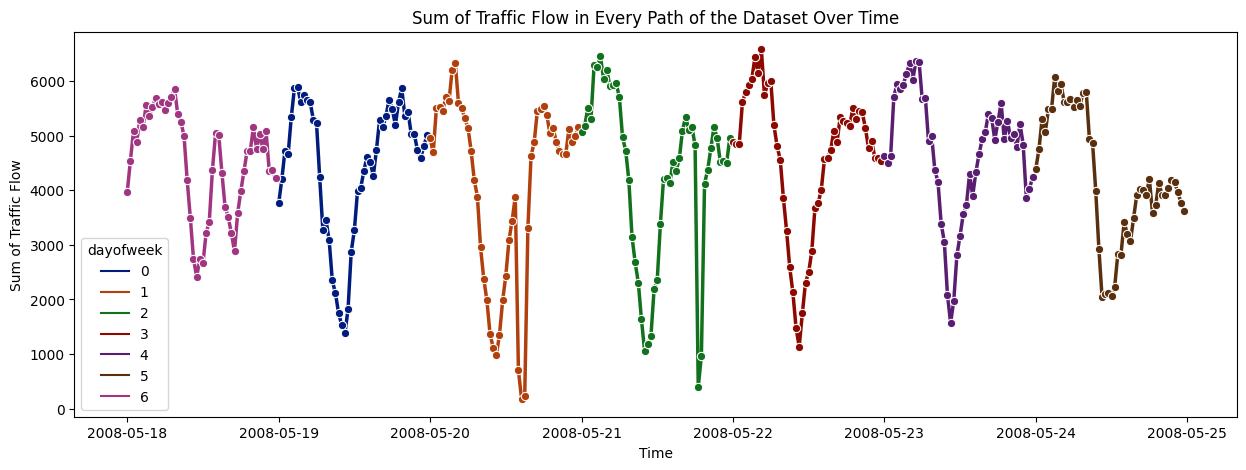

time: 976 ms (started: 2023-08-11 10:51:01 +00:00)


In [24]:
# create a custom dark color palette
dark_palette = sns.color_palette('dark', n_colors=8)

# create a plot to view the results
plt.figure(figsize=(15,5))
sns.lineplot(grouped_df,x=grouped_df.index,y='Traffic Flow',hue='dayofweek',marker='o', palette=dark_palette,linewidth=2.5)
plt.xlabel('Time')
plt.ylabel('Sum of Traffic Flow')
plt.title('Sum of Traffic Flow in Every Path of the Dataset Over Time')
plt.show()

Based on graph above, we see that for each day, there is a seasonality pattern. In the noon hours Traffic Flow is lower than in the mornnings or in the evenings.

##### Visualize traffic flow per day and per 3hour time inteval

Text(0.5, 0, 'Time information every 30 minutes')

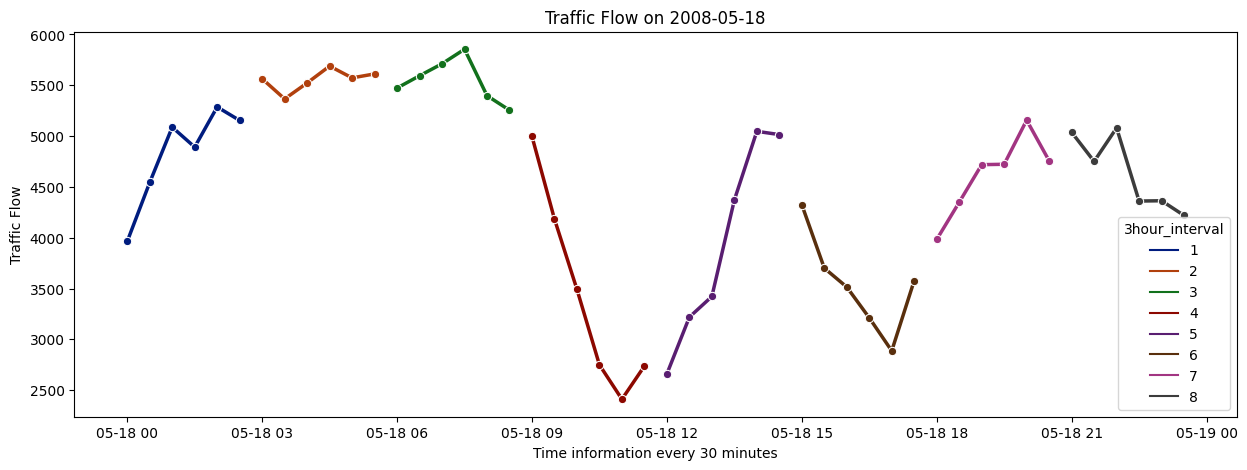

time: 936 ms (started: 2023-08-11 10:51:02 +00:00)


In [25]:
# traffic flow on 2008-05-18
pl = grouped_df[(grouped_df.index >= '2008-05-18 00:00:00') & (grouped_df.index < '2008-05-19 00:00:00')]

# create a custom dark color palette
dark_palette = sns.color_palette('dark', n_colors=8)

# plot the data
plt.figure(figsize=(15,5))
sns.lineplot(pl,x='Time Column',y='Traffic Flow',hue='3hour_interval',marker='o', palette=dark_palette,linewidth=2.5)
plt.title("Traffic Flow on 2008-05-18")
plt.xlabel("Time information every 30 minutes")

Text(0.5, 0, 'Time information every 30 minutes')

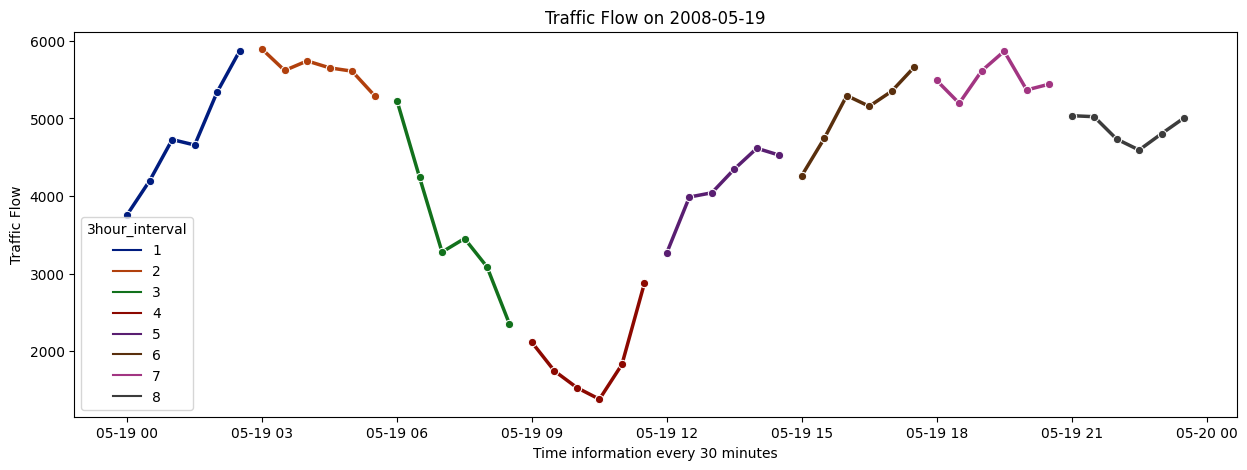

time: 925 ms (started: 2023-08-11 10:51:03 +00:00)


In [26]:
# traffic flow on 2008-05-19
pl = grouped_df[(grouped_df.index >= '2008-05-19 00:00:00') & (grouped_df.index < '2008-05-20 00:00:00')]

# create a custom dark color palette
dark_palette = sns.color_palette('dark', n_colors=8)

# plot the data
plt.figure(figsize=(15,5))
sns.lineplot(pl,x='Time Column',y='Traffic Flow',hue='3hour_interval',marker='o', palette=dark_palette,linewidth=2.5)
plt.title("Traffic Flow on 2008-05-19")
plt.xlabel("Time information every 30 minutes")

Text(0.5, 0, 'Time information every 30 minutes')

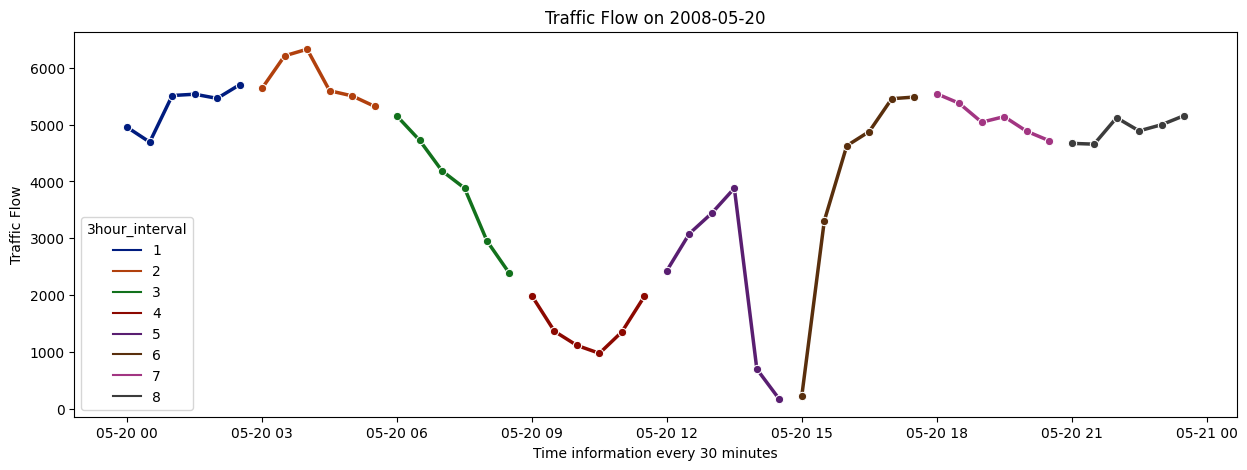

time: 1.31 s (started: 2023-08-11 10:51:04 +00:00)


In [27]:
# traffic flow on 2008-05-20
pl = grouped_df[(grouped_df.index >= '2008-05-20 00:00:00') & (grouped_df.index < '2008-05-21 00:00:00')]

# create a custom dark color palette
dark_palette = sns.color_palette('dark', n_colors=8)

# plot the data
plt.figure(figsize=(15,5))
sns.lineplot(pl,x='Time Column',y='Traffic Flow',hue='3hour_interval',marker='o', palette=dark_palette,linewidth=2.5)
plt.title("Traffic Flow on 2008-05-20")
plt.xlabel("Time information every 30 minutes")

Text(0.5, 0, 'Time information every 30 minutes')

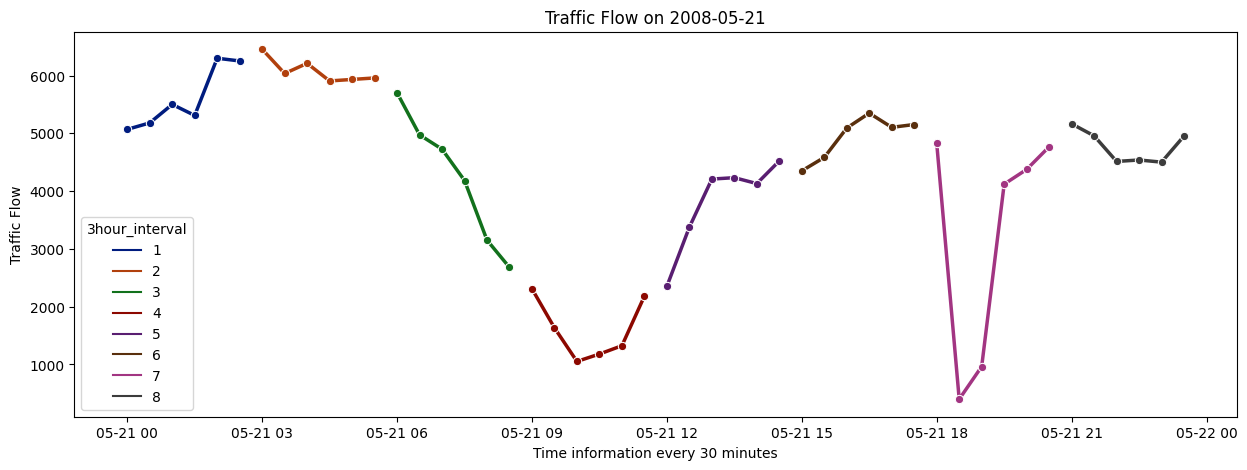

time: 970 ms (started: 2023-08-11 10:51:06 +00:00)


In [28]:
# traffic flow on 2008-05-21
pl = grouped_df[(grouped_df.index >= '2008-05-21 00:00:00') & (grouped_df.index < '2008-05-22 00:00:00')]

# create a custom dark color palette
dark_palette = sns.color_palette('dark', n_colors=8)

# plot the data
plt.figure(figsize=(15,5))
sns.lineplot(pl,x='Time Column',y='Traffic Flow',hue='3hour_interval',marker='o', palette=dark_palette,linewidth=2.5)
plt.title("Traffic Flow on 2008-05-21")
plt.xlabel("Time information every 30 minutes")

Text(0.5, 0, 'Time information every 30 minutes')

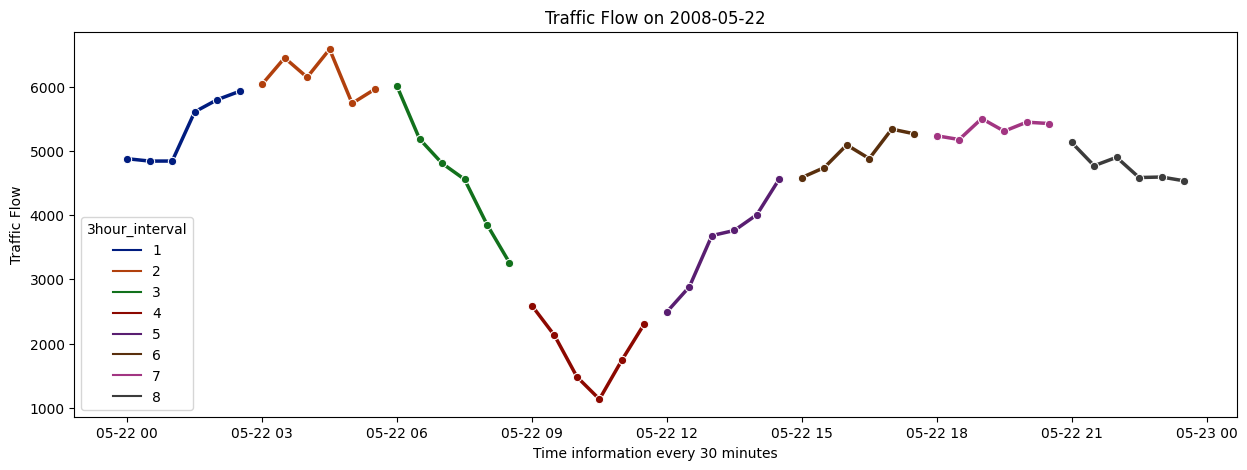

time: 1.07 s (started: 2023-08-11 10:51:07 +00:00)


In [29]:
# traffic flow on 2008-05-22
pl = grouped_df[(grouped_df.index >= '2008-05-22 00:00:00') & (grouped_df.index < '2008-05-23 00:00:00')]

# create a custom dark color palette
dark_palette = sns.color_palette('dark', n_colors=8)

# plot the data
plt.figure(figsize=(15,5))
sns.lineplot(pl,x='Time Column',y='Traffic Flow',hue='3hour_interval',marker='o', palette=dark_palette,linewidth=2.5)
plt.title("Traffic Flow on 2008-05-22")
plt.xlabel("Time information every 30 minutes")

Text(0.5, 0, 'Time information every 30 minutes')

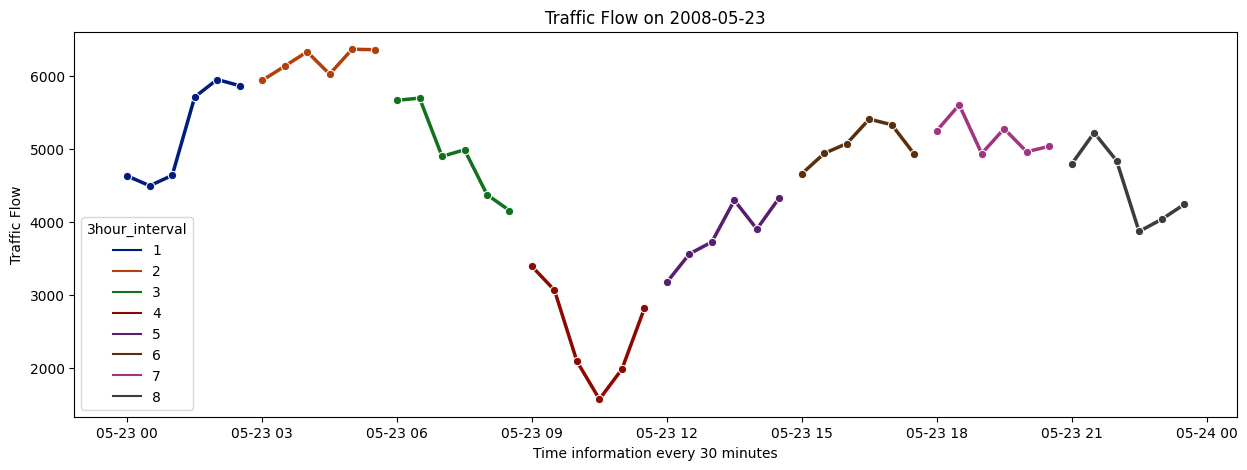

time: 708 ms (started: 2023-08-11 10:51:08 +00:00)


In [30]:
# traffic flow on 2008-05-23
pl = grouped_df[(grouped_df.index >= '2008-05-23 00:00:00') & (grouped_df.index < '2008-05-24 00:00:00')]

# create a custom dark color palette
dark_palette = sns.color_palette('dark', n_colors=8)

# plot the data
plt.figure(figsize=(15,5))
sns.lineplot(pl,x='Time Column',y='Traffic Flow',hue='3hour_interval',marker='o', palette=dark_palette,linewidth=2.5)
plt.title("Traffic Flow on 2008-05-23")
plt.xlabel("Time information every 30 minutes")

Text(0.5, 0, 'Time information every 30 minutes')

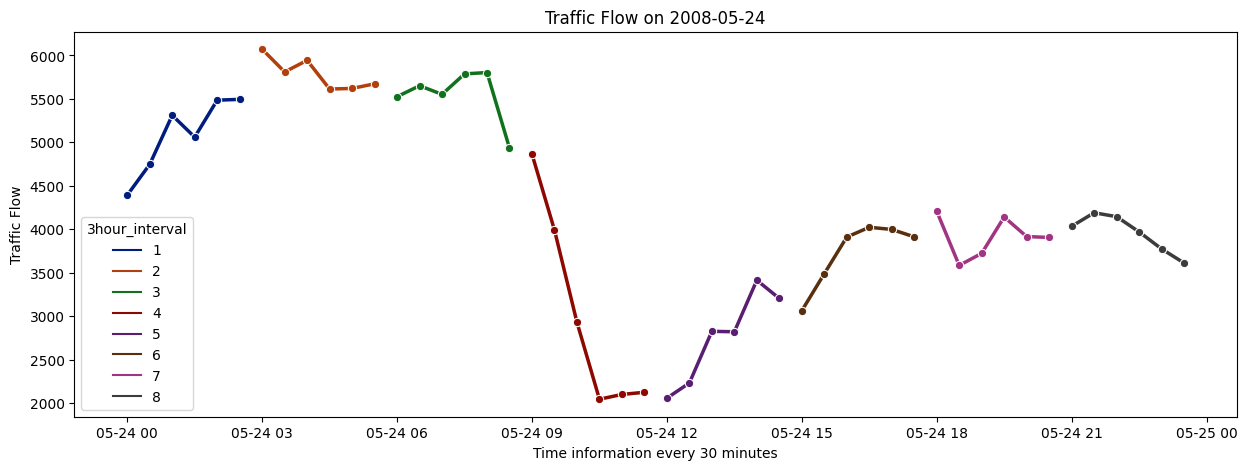

time: 1.29 s (started: 2023-08-11 10:51:08 +00:00)


In [31]:
# traffic flow on 2008-05-24
pl = grouped_df[(grouped_df.index >= '2008-05-24 00:00:00') & (grouped_df.index < '2008-05-25 00:00:00')]

# create a custom dark color palette
dark_palette = sns.color_palette('dark', n_colors=8)

# plot the data
plt.figure(figsize=(15,5))
sns.lineplot(pl,x='Time Column',y='Traffic Flow',hue='3hour_interval',marker='o', palette=dark_palette,linewidth=2.5)
plt.title("Traffic Flow on 2008-05-24")
plt.xlabel("Time information every 30 minutes")

##### Find highly correlated data in the dataset

<Axes: >

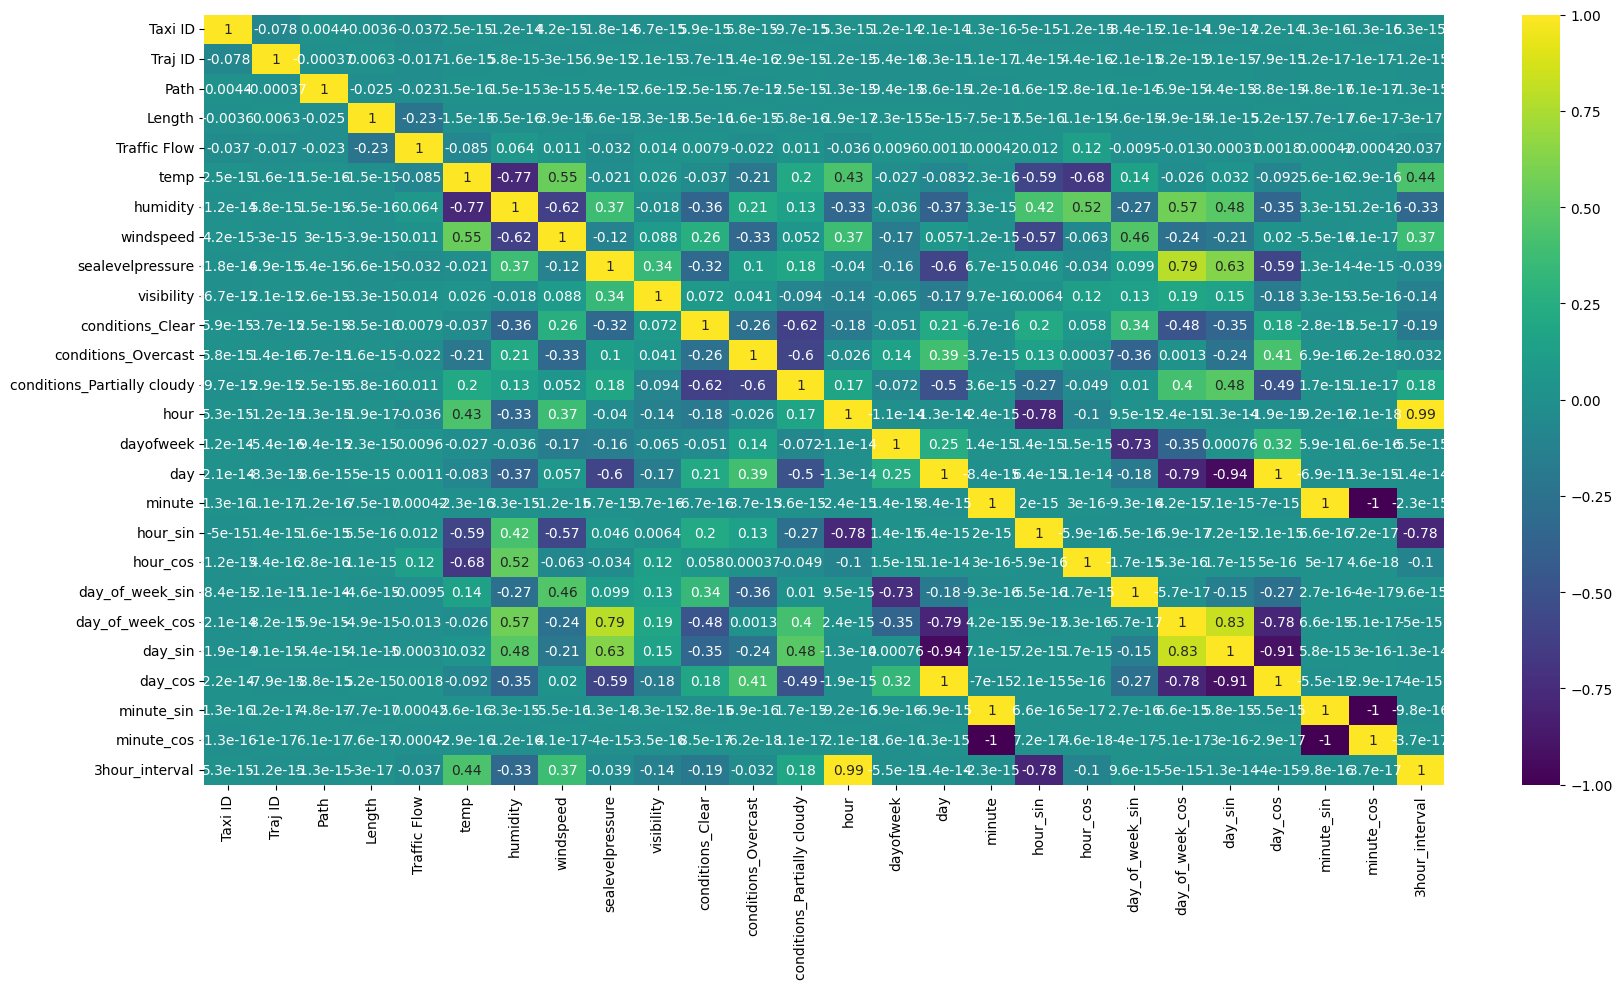

time: 9.07 s (started: 2023-08-11 10:51:10 +00:00)


In [32]:
plt.figure(figsize=(20,10))
sns.heatmap(time_series_weather.corr(), annot=True, cmap='viridis')

Based on the above heatmap, we see that there are some features that are highly correlated. For example,
temperature is correlated wiith humidity, windspeed, the hour of day, 3hour_interval and circular encoding of hour feature. Based on this heatmap above, we can choose the features that will be used in the final model.

### Phase 5: Build machine learning models for traffic flow forecasting
In this step, the following commands are executed:
- Train and Test split
- Find the best lookback timesteps for our XGBoost model
- Perform Grid Search CV to find the optimum parameters for the XGBoost model
- Train XGboost model (1)
- Train an LSTM model (2)
- Train a random forest model (3)
- Perform Grid Search CV to find the optimum parameters for the random forest model
- Train Encodel-Decoder model (4)
- Visualise the losses for each model
- Test on testing set for each model
- Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them
- Make visualizations on actual vs predicted traffic flow data

#### Step 1: Train - Test split
In this step, we split the data into two datasets, train and test.
The time inteval of all observations in this dataset are within [18-05-2008, 24-05-2008].
- Train dataset contains all the data for each path till 2008-05-23 inclusive.
- The rest of the data (the most resent ones) are in the test dataset

In [33]:
# sort the time series data
time_series_weather.sort_values(by=['Path','Time Column'], inplace=True)

time: 362 ms (started: 2023-08-11 10:51:19 +00:00)


In [34]:
# define train data
train = time_series_weather.loc[time_series_weather['Time Column'] < '2008-05-24']

# define test data
test = time_series_weather.loc[time_series_weather['Time Column'] >= '2008-05-24']

# print the results
print("Train set shape: ",train.shape)
print("Test set shape: ",test.shape)

Train set shape:  (288000, 27)
Test set shape:  (48000, 27)
time: 100 ms (started: 2023-08-11 10:51:19 +00:00)


In [35]:
# redefine train and test sets based on correlated features (drop highly correlated features)
train = train.drop(['Time Column','hour', 'hour_sin','day_of_week_cos', 'dayofweek', 'day', 'minute'],axis=1)
test = test.drop(['Time Column','hour', 'hour_sin','day_of_week_cos', 'dayofweek', 'day', 'minute'],axis=1)

time: 24.2 ms (started: 2023-08-11 10:51:19 +00:00)


#### Step 2: Find the best lookback timesteps for our XGBoost model
In this step, we define the optimum lookback timestep number for our sliding window. This optimum number will be used by the model for forecasting.

##### Step 2a: Create empty dataframe to store the scores per lookback timesteps

In [36]:
# find best lookback timesteps to perform analysis. Save those scores in a separate dataframe
lookback_scores = pd.DataFrame(columns=['#Timesteps','XGBoost Score'])
lookback_scores['#Timesteps'] = 0
lookback_scores['XGBoost Score'] = 0

time: 6.78 ms (started: 2023-08-11 10:51:19 +00:00)


##### Step 2b: Create function that converts the data into a supervised problem
Consider for each path n_in timesteps of traffic flow in the past, in order to predict the n_out traffic flow timesteps in the future.

In [37]:
from pandas import DataFrame
from pandas import concat

# create functio for generating (X, y) pairs
def series_to_supervised(data, n_in=1, n_out=1):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('Traffic Flow %d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('Traffic Flow %d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('Traffic Flow %d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    return agg

time: 1.56 ms (started: 2023-08-11 10:51:19 +00:00)


In [38]:
"""
Convert the training data into a supervised dataset. Create X,y pairs of the traffic column information.
Then, concatenate the rest of the culumns.
"""
def generate_X_y_pairs(data,n_in=1,n_out=1):
    new_data = pd.DataFrame()
    for item in data['Path'].unique():

        # call function only for traffic flow columns
        supervised_traffic_flow = series_to_supervised(pd.DataFrame(data[data['Path'] == item]['Traffic Flow']), n_in, n_out)

        # the rest of the columns are concatenated as they were
        supervised_traffic_flow = pd.concat([supervised_traffic_flow, time_series_weather[time_series_weather['Path'] == item]], axis=1)

        new_data = pd.concat([new_data,supervised_traffic_flow])

    new_data.dropna(inplace=True)
    return new_data

time: 1.01 ms (started: 2023-08-11 10:51:19 +00:00)


##### Step 2c: Create a loop. In each loop, we are doing the following:
- 0. Convert train and test sets into supervised problem with lookback timesteps.
- 1. Define features and labels.
- 2. Train the XGboost model with defult parameters
- 3. Predict on the test set
- 4. Save RMSE in a dataframe

In [39]:
# import libraries
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

time: 356 ms (started: 2023-08-11 10:51:20 +00:00)


In [40]:
for lookback in [2,3,4,5,6]: # different lookback sizes

    # convert train and test data to supervised
    train_s = generate_X_y_pairs(train,lookback)
    test_s = generate_X_y_pairs(test,lookback)

    print("Lookback = "+str(lookback)+" - To supervised: Completed!")

    # add rolling mean information
    train_s['rolling_mean'] = 0
    test_s['rolling_mean'] = 0

    train_s['rolling_mean'] = train_s.iloc[:,0:lookback].mean(axis=1)
    test_s['rolling_mean'] = test_s.iloc[:,0:lookback].mean(axis=1)

    # define features
    features_s = train_s.drop(['Time Column','Traffic Flow','Traffic Flow 1(t)'],axis=1).columns

    # define label
    labels_s = ['Traffic Flow 1(t)']

    # create X_train and y_train datasets
    X_train_s = train_s[features_s]
    y_train_s = train_s[labels_s]

    # create X_test and y_test datasets
    X_test_s = test_s[features_s]
    y_test_s = test_s[labels_s]

    print("Lookback = "+str(lookback)+" - Train and Test sets: Completed!")

    # define XGBoost regression model
    reg = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=1000,early_stopping_rounds = 5)

    # train the XGBoost model with feature weights (use validation set on test data)
    reg.fit(X_train_s, y_train_s, eval_set=[(X_train_s, y_train_s), (X_test_s,y_test_s)],verbose=False)

    print("Lookback = "+str(lookback)+" - Trainning: Completed!")

    # make predictions
    y_pred_s = reg.predict(X_test_s)

    # calculate RMSE score
    rmse = mean_squared_error(y_test_s, y_pred_s, squared=False)

    # create a new row as a dictionary
    new_row = {'#Timesteps': lookback, 'XGBoost Score': rmse}

    # append the new row to the DataFrame
    lookback_scores = lookback_scores.append(new_row, ignore_index=True)

    print("Lookback = "+str(lookback)+" - Saved Results: Completed!")

Lookback = 2 - To supervised: Completed!
Lookback = 2 - Train and Test sets: Completed!
Lookback = 2 - Trainning: Completed!
Lookback = 2 - Saved Results: Completed!
Lookback = 3 - To supervised: Completed!
Lookback = 3 - Train and Test sets: Completed!
Lookback = 3 - Trainning: Completed!
Lookback = 3 - Saved Results: Completed!
Lookback = 4 - To supervised: Completed!
Lookback = 4 - Train and Test sets: Completed!
Lookback = 4 - Trainning: Completed!
Lookback = 4 - Saved Results: Completed!
Lookback = 5 - To supervised: Completed!
Lookback = 5 - Train and Test sets: Completed!
Lookback = 5 - Trainning: Completed!
Lookback = 5 - Saved Results: Completed!
Lookback = 6 - To supervised: Completed!
Lookback = 6 - Train and Test sets: Completed!
Lookback = 6 - Trainning: Completed!
Lookback = 6 - Saved Results: Completed!
time: 3min 59s (started: 2023-08-11 10:51:20 +00:00)


#####  Step 2d: Print RMSE scores over lookback timesteps into a graph

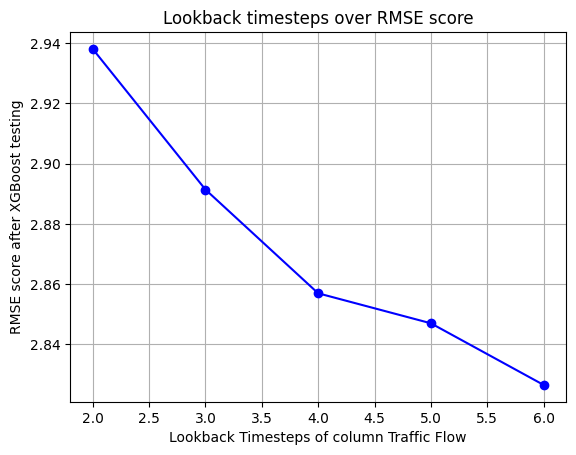

time: 222 ms (started: 2023-08-11 10:55:20 +00:00)


In [41]:
# plot the data
plt.plot(lookback_scores['#Timesteps'], lookback_scores['XGBoost Score'], linestyle='-', marker='o', color='b')

# set plot title and axis labels
plt.title('Lookback timesteps over RMSE score')
plt.xlabel('Lookback Timesteps of column Traffic Flow')
plt.ylabel('RMSE score after XGBoost testing')

# add gridlines
plt.grid(True)

# show the plot
plt.show()

In [42]:
# find the timesteps corresponding to the minimum RMSE score
optimum_lookback = int(lookback_scores['#Timesteps'].loc[lookback_scores['XGBoost Score'].idxmin()])

time: 1.21 ms (started: 2023-08-11 10:55:20 +00:00)


#### Step 3: Perform Grid Search CV to find the optimum parameters for the XGBoost model
This step is essential to tune correctly the XGboost model.

##### Step 3a: Split train and test into supervised problem, based on optimum lookback timesteps that found above.

In [43]:
# convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train,optimum_lookback)
test = generate_X_y_pairs(test,optimum_lookback)

time: 34.8 s (started: 2023-08-11 10:55:20 +00:00)


##### Step 3b: Extract features about trend of time series
In this step we define the rolling mean and rolling variance of a window. Since we are trying to forecast the last value of each window, only the first optimum_lookback values in the window are used to compute rolling features. The last value (that we are trying to forecast) is not included.

In [44]:
# add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

train['rolling_var'] = 0
test['rolling_var'] = 0

# calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:optimum_lookback].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

# calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:optimum_lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:optimum_lookback].var(axis=1)

time: 88.7 ms (started: 2023-08-11 10:55:55 +00:00)


#####  Step 3c: Define labels and features
- Features will help the XGboost algorithm to predict the output value, the label. We will use all the traffic flow information at previous timesteps (t-n,t-n+1...,t-2,t-1), as well as the rest of the features (time and trend information) as features.
- Label will be out target value, the Traffic Flow at timestep t.

In [45]:
# define features
features = train.drop(['Time Column','Traffic Flow 1(t)','Traffic Flow','hour', 'hour_sin','day_of_week_cos', 'dayofweek', 'day', 'minute'],axis=1).columns

# define labels
labels = ['Traffic Flow 1(t)']

# create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

time: 93.9 ms (started: 2023-08-11 10:55:55 +00:00)


In [46]:
# show shape information about X and y training and testing sets
print("Shape of X_train is: ",X_train.shape)
print("Shape of y_train is: ",y_train.shape)
print("Shape of X_test is: ",X_test.shape)
print("Shape of y_test is: ",y_test.shape)

Shape of X_train is:  (282000, 27)
Shape of y_train is:  (282000, 1)
Shape of X_test is:  (42000, 27)
Shape of y_test is:  (42000, 1)
time: 7.78 ms (started: 2023-08-11 10:55:55 +00:00)


##### Step 3d: Apply GridSearchCV
Use a 5-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [47]:
from sklearn.model_selection import GridSearchCV

time: 427 µs (started: 2023-08-11 10:55:55 +00:00)


In [48]:
# tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [500],
    "learning_rate": [0.1],
    "max_depth": [3,9],
    "objective":['reg:squarederror'],
    "gamma": [0,1,2],
    "alpha": [0,0.1,1]
}

# define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        verbose=1,
                        scoring= "neg_mean_squared_error")

# train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[0]	validation_0-rmse:7.08921	validation_1-rmse:6.39188
[1]	validation_0-rmse:6.54564	validation_1-rmse:5.89362
[2]	validation_0-rmse:6.06817	validation_1-rmse:5.45406
[3]	validation_0-rmse:5.64946	validation_1-rmse:5.07290
[4]	validation_0-rmse:5.28105	validation_1-rmse:4.73737
[5]	validation_0-rmse:4.96085	validation_1-rmse:4.44733
[6]	validation_0-rmse:4.68466	validation_1-rmse:4.19642
[7]	validation_0-rmse:4.44571	validation_1-rmse:3.98471
[8]	validation_0-rmse:4.23999	validation_1-rmse:3.80063
[9]	validation_0-rmse:4.06409	validation_1-rmse:3.64562
[10]	validation_0-rmse:3.91458	validation_1-rmse:3.51816
[11]	validation_0-rmse:3.78674	validation_1-rmse:3.40876
[12]	validation_0-rmse:3.67895	validation_1-rmse:3.32094
[13]	validation_0-rmse:3.58787	validation_1-rmse:3.24695
[14]	validation_0-rmse:3.51071	validation_1-rmse:3.18458
[15]	validation_0-rmse:3.44625	validation_1-rmse:3.13022
[16]	validation_0-rmse:3.39179	valida

#### Step 4: Create dataframe to save actual values and model predictions

In [49]:
total_predictions = pd.DataFrame(index=pd.to_datetime(test['Time Column']))
total_predictions['Actual'] = y_test['Traffic Flow 1(t)'].values
total_predictions['Path'] = X_test['Path'].values

time: 155 ms (started: 2023-08-11 11:21:09 +00:00)


#### Step 5: Train an XGboost model
We will fit all the data in this model using the optimum parameters we found above.

Create XGBoost model and train it

In [50]:
# define XGBoost regressor
reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    early_stopping_rounds=5,
    max_depth=9 ,
    learning_rate=0.1,
    gamma=1,
    alpha=0.1
)

# train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)],
        verbose=True)

[0]	validation_0-rmse:7.05587	validation_1-rmse:6.39348
[1]	validation_0-rmse:6.48189	validation_1-rmse:5.89698
[2]	validation_0-rmse:5.97405	validation_1-rmse:5.45904
[3]	validation_0-rmse:5.52622	validation_1-rmse:5.07593
[4]	validation_0-rmse:5.13153	validation_1-rmse:4.74001
[5]	validation_0-rmse:4.78667	validation_1-rmse:4.45262
[6]	validation_0-rmse:4.48513	validation_1-rmse:4.20581
[7]	validation_0-rmse:4.22310	validation_1-rmse:3.98620
[8]	validation_0-rmse:3.99641	validation_1-rmse:3.80620
[9]	validation_0-rmse:3.79988	validation_1-rmse:3.64931
[10]	validation_0-rmse:3.62866	validation_1-rmse:3.51586
[11]	validation_0-rmse:3.48341	validation_1-rmse:3.40705
[12]	validation_0-rmse:3.35842	validation_1-rmse:3.32006
[13]	validation_0-rmse:3.25008	validation_1-rmse:3.24397
[14]	validation_0-rmse:3.15826	validation_1-rmse:3.17856
[15]	validation_0-rmse:3.08109	validation_1-rmse:3.12149
[16]	validation_0-rmse:3.01450	validation_1-rmse:3.07642
[17]	validation_0-rmse:2.95676	validation

XGBRegressor(alpha=0.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

time: 2min (started: 2023-08-11 11:21:09 +00:00)


Feature Importance of XGBoost model
Show how our model used the feautres, in order to perform splits.

<Figure size 1500x500 with 0 Axes>

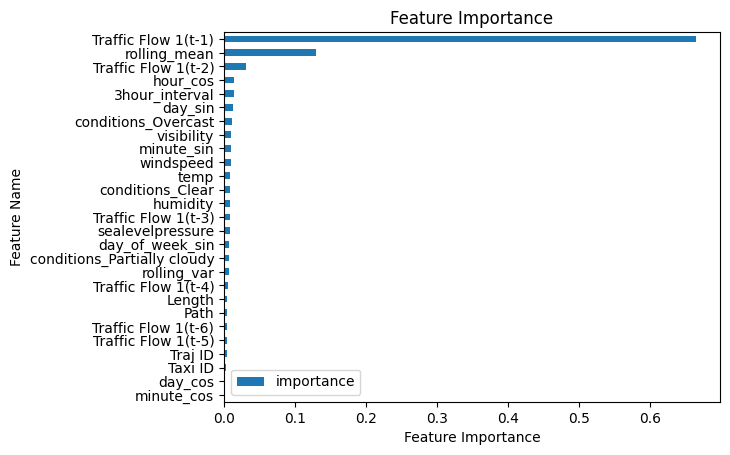

time: 389 ms (started: 2023-08-11 11:23:10 +00:00)


In [51]:
# show how much each of the features was used in our regression analysis
plt.figure(figsize=(15,5))
fi = pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.show()

Plot train and validation errors of XGBoost model in the same graph

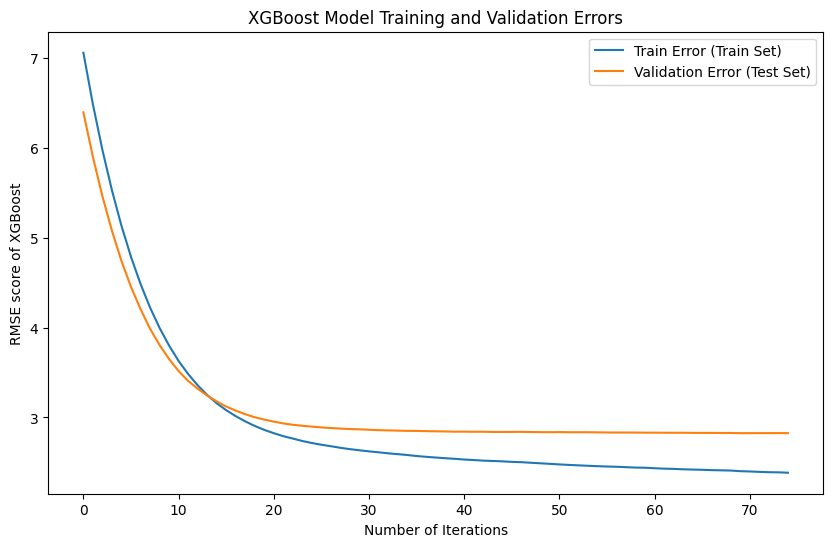

time: 275 ms (started: 2023-08-11 11:23:10 +00:00)


In [52]:
# acquire the values of train and validation errors
results = reg.evals_result()
train_errors = results['validation_0']['rmse']
validation_errors = results['validation_1']['rmse']

# plot the validation and training errors
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train Error (Train Set)')
plt.plot(validation_errors, label='Validation Error (Test Set)')
plt.xlabel('Number of Iterations')
plt.ylabel('RMSE score of XGBoost')
plt.title('XGBoost Model Training and Validation Errors')
plt.legend()
plt.show()

Make predictions on the test set

In [53]:
y_pred_xgboost = reg.predict(X_test)

time: 102 ms (started: 2023-08-11 11:23:10 +00:00)


In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.7473074360425207
RMSE score: 2.8254786229281033
time: 7.5 ms (started: 2023-08-11 11:23:11 +00:00)


Show example of how well the model learned the trainning data.


Use a random path to visualize the results

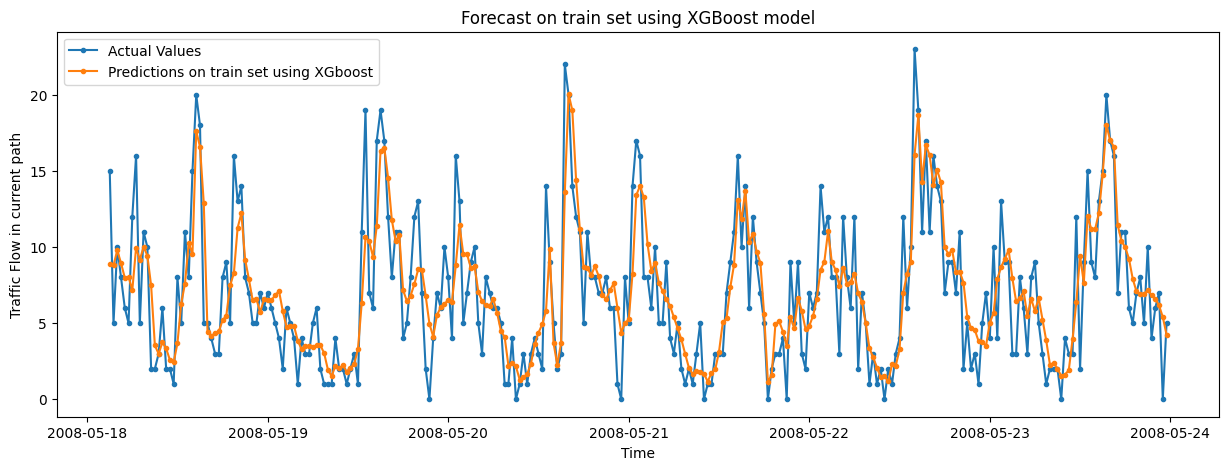

time: 1.11 s (started: 2023-08-11 11:23:11 +00:00)


In [55]:
# predict on the trainning set
y_pred_train = reg.predict(X_train)

# add information in the trainning set
train_predictions = pd.DataFrame(index=pd.to_datetime(train['Time Column']))
train_predictions.insert(0,'Train Actual',y_train['Traffic Flow 1(t)'].values)
train_predictions.insert(1,'Train Predicted',y_pred_train)
train_predictions.insert(2,'Path',X_train['Path'].values)

# plot an example of the train-predictions at path 0 of the datase
plt.figure(figsize=(15,5))
plt.plot(train_predictions[train_predictions['Path']==0]['Train Actual'],".-",label='Actual Values')
plt.plot(train_predictions[train_predictions['Path']==0]['Train Predicted'],".-",label='Predictions on train set using XGboost')
plt.xlabel('Time')
plt.ylabel('Traffic Flow in current path')
plt.title('Forecast on train set using XGBoost model')
plt.legend()
plt.show()

As we can see, the model has learned the trend and (almost) the seasonality of the data.

Despite the non-linearity of Traffic Flow, XGBoost performs quite well!

Show an example of actual values vs predicted on test set

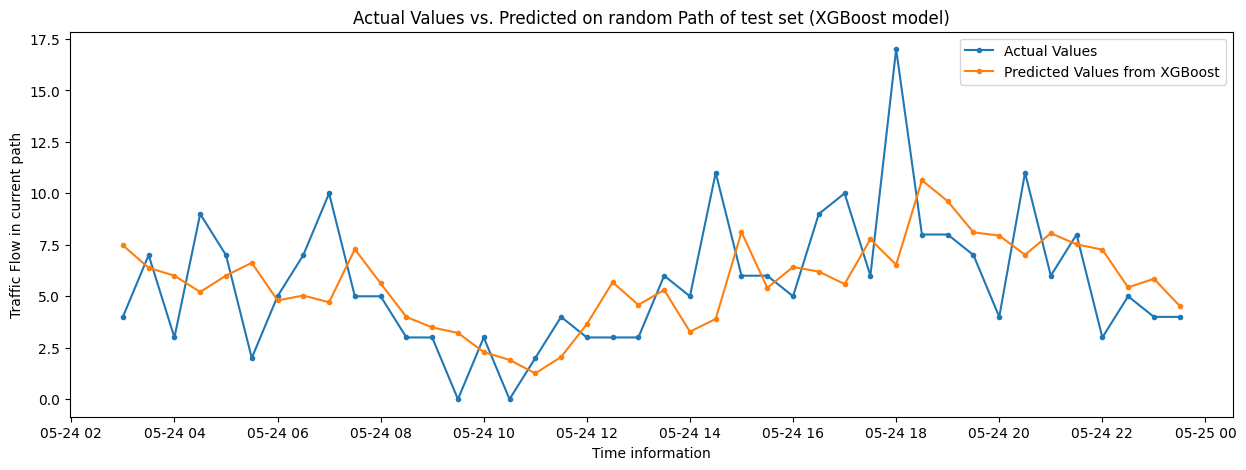

time: 385 ms (started: 2023-08-11 11:23:12 +00:00)


In [56]:
test_predictions = pd.DataFrame(index=pd.to_datetime(test['Time Column']))
test_predictions.insert(0,'Test Actual',y_test['Traffic Flow 1(t)'].values)
test_predictions.insert(1,'Test Predicted',y_pred_xgboost)
test_predictions.insert(2,'Path',X_test['Path'].values)

# plot an example of the train-predictions
plt.figure(figsize=(15,5))
plt.plot(test_predictions[test_predictions['Path']==0]['Test Actual'],".-",label='Actual Values')
plt.plot(test_predictions[test_predictions['Path']==0]['Test Predicted'],".-",label='Predicted Values from XGBoost')
plt.xlabel('Time information')
plt.ylabel('Traffic Flow in current path')
plt.title('Actual Values vs. Predicted on random Path of test set (XGBoost model)')
plt.legend()
plt.show()

#### Step 6: Train LSTM for time series forecasting
This is the second model that we will train on the same dataset. We use the optimum lookback score that we computed above, before training the XGboost algorithm. This ensures that the LSTM model will be trained on the same data as the XGboost algorithm.

##### Step 6a: Create the train and test sets as before, then scale them
Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [57]:
# import library for data scaling
from sklearn.preprocessing import MinMaxScaler

time: 459 µs (started: 2023-08-11 11:23:12 +00:00)


In [58]:
# scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

time: 128 ms (started: 2023-08-11 11:23:12 +00:00)


In [59]:
# create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

time: 618 ms (started: 2023-08-11 11:23:12 +00:00)


In [60]:
# create 3D test set FOR LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

time: 153 ms (started: 2023-08-11 11:23:13 +00:00)


In [61]:
# print shapes of the created sets
trainX.shape, trainY.shape, testX.shape, testY.shape

((282000, 1, 27), (282000, 1, 1), (42000, 1, 27), (42000, 1, 1))

time: 8 ms (started: 2023-08-11 11:23:13 +00:00)


##### Step 6b: Use the LSTM model for forecasting

Import libraries and define the LSTM structure

In [62]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import tensorflow as tf

time: 5.6 s (started: 2023-08-11 11:23:13 +00:00)


In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [63]:
# define LSTM model
model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# additional Dense layers
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='linear'))

# output layer
model.add(Dense(trainY.shape[1]))

# add early stopping mechanism
early_stopping = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

time: 4.45 s (started: 2023-08-11 11:23:19 +00:00)


Compile the model

In [64]:
# compile LSTM model
model.compile(optimizer='adam', loss='mse')

time: 22 ms (started: 2023-08-11 11:23:23 +00:00)


Train the model

In [65]:
# fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          verbose=1,
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 17s 31ms/step - loss: 0.0104 - val_loss: 0.0132
Epoch 2/50
100/100 [==============================] - 1s 15ms/step - loss: 0.0087 - val_loss: 0.0045
Epoch 3/50
100/100 [==============================] - 2s 23ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 4/50
100/100 [==============================] - 4s 41ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 5/50
100/100 [==============================] - 2s 20ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 6/50
100/100 [==============================] - 2s 17ms/step - loss: 0.0026 - val_loss: 0.0038
Epoch 7/50
100/100 [==============================] - 3s 30ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 8/50
100/100 [==============================] - 2s 23ms/step - loss: 0.0025 - val_loss: 0.0035
Epoch 9/50
100/100 [==============================] - 4s 36ms/step - loss: 0.0024 - val_loss: 0.0035
Epoch 10/50
100/100 [==============================] - 3s 33ms/step - loss: 0.0024 - val_l

In [66]:
# evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

1313/1313 [==============================] - 8s 6ms/step - loss: 0.0032
Test Loss: 0.0031872279942035675
time: 56 s (started: 2023-08-11 11:25:03 +00:00)


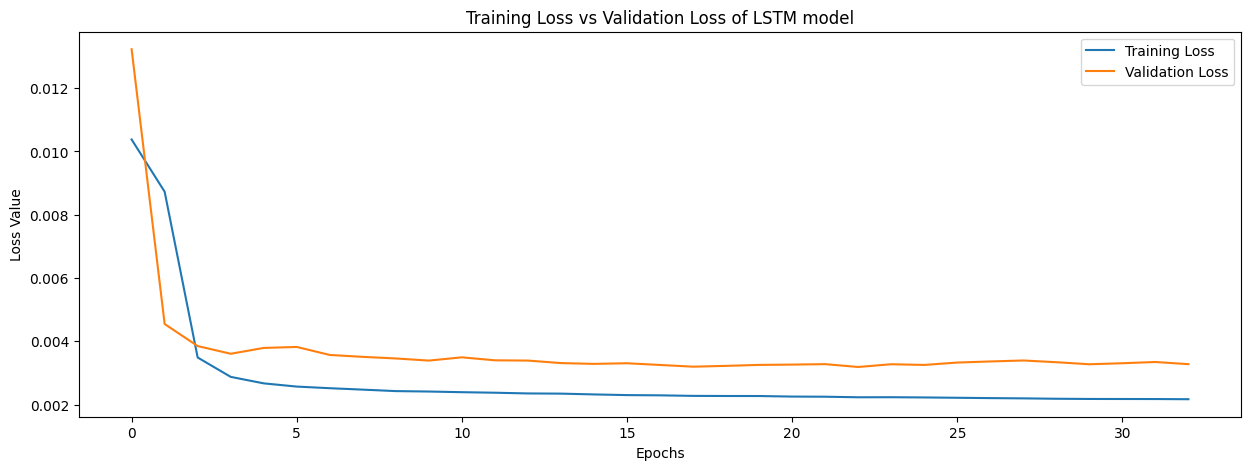

time: 269 ms (started: 2023-08-11 11:25:59 +00:00)


In [67]:
### PLOT TRAIN VS. VALIDATION LOSS OF LSTM MODEL ###

# extract training and validation losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# plot the losses
plt.figure(figsize=(15,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.title('Training Loss vs Validation Loss of LSTM model')
plt.legend()

# show the plot
plt.show()

Make predictions on test set

In [68]:
# predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

1313/1313 [==============================] - 8s 6ms/step
time: 11 s (started: 2023-08-11 11:25:59 +00:00)


Evaluate the LSTM model

In [69]:
# calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.8777173583869424
RMSE LSTM score: 2.9356880323268197
time: 7.25 ms (started: 2023-08-11 11:26:10 +00:00)


Show example of how well the LSTM captured/learned the train data

8813/8813 [==============================] - 45s 5ms/step


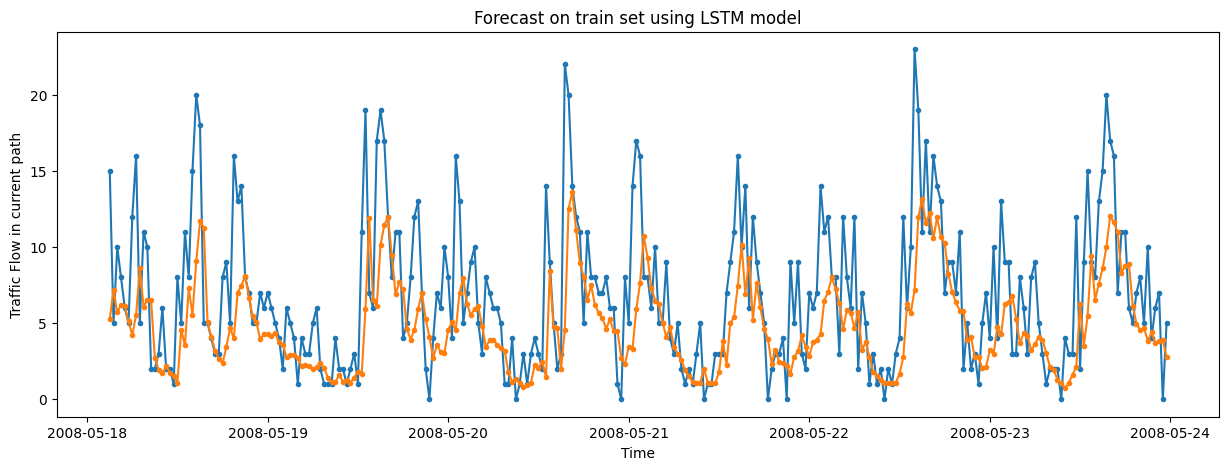

time: 1min 22s (started: 2023-08-11 11:26:10 +00:00)


In [70]:
# predict on the trainning set
y_pred_train_LSTM = model.predict(trainX)

# add information in the trainning set
train_predictions = pd.DataFrame(index=pd.to_datetime(train['Time Column']))
train_predictions.insert(0,'Train Actual',y_train['Traffic Flow 1(t)'].values)
train_predictions.insert(1,'Train Predicted',scaler.inverse_transform(y_pred_train_LSTM.reshape(-1,1)))
train_predictions.insert(2,'Path',X_train['Path'].values)

# plot an example of the train-predictions
plt.figure(figsize=(15,5))
plt.plot(train_predictions[train_predictions['Path']==0][['Train Actual','Train Predicted']],".-")
plt.xlabel('Time')
plt.ylabel('Traffic Flow in current path')
plt.title('Forecast on train set using LSTM model')
plt.show()

#### Step 7: Create Random Forest model
This is the third model that we train on the same data, in order to forecast the traffic flow prediction. This algorithm is (almost) the same with the XGBoost, because both of them use decision trees to make forecasts.

In [71]:
# import Random Forest algorithm
from sklearn.ensemble import RandomForestRegressor

time: 248 ms (started: 2023-08-11 11:27:33 +00:00)


##### Step 7a: Find optimum parameters for random forest

In [72]:
# define the parameter grid for the grid search
param_grid = {
    'max_depth': [5, 7],
    'min_samples_split': [5, 10],
    'n_estimators': [50]
}

# create the Random Forest model
rf_model = RandomForestRegressor(n_jobs=-1)

# create the GridSearchCV object
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='neg_mean_squared_error',verbose=1)

# fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# print the best parameters and the best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 50}
Best Score: -9.332991005441832
time: 6min 7s (started: 2023-08-11 11:27:33 +00:00)


##### Step 7b: Create and train the best random forest model that occured after grid search.

In [73]:
# get the best model after Grid Search
best_model = RandomForestRegressor(n_estimators=150,
                                  min_samples_split=10,
                                  max_depth=7,
                                  verbose=1,
                                  n_jobs=-1)

time: 451 µs (started: 2023-08-11 11:33:41 +00:00)


In [74]:
# train the best Random Forest model
best_model.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.3min finished


RandomForestRegressor(max_depth=7, min_samples_split=10, n_estimators=150,
                      n_jobs=-1, verbose=1)

time: 2min 16s (started: 2023-08-11 11:33:41 +00:00)


##### Step 7c: Make predictions on train set

In [75]:
# make predictions on the test set
y_pred_rf = best_model.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s


time: 285 ms (started: 2023-08-11 11:35:58 +00:00)


[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:    0.3s finished


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:    2.8s finished


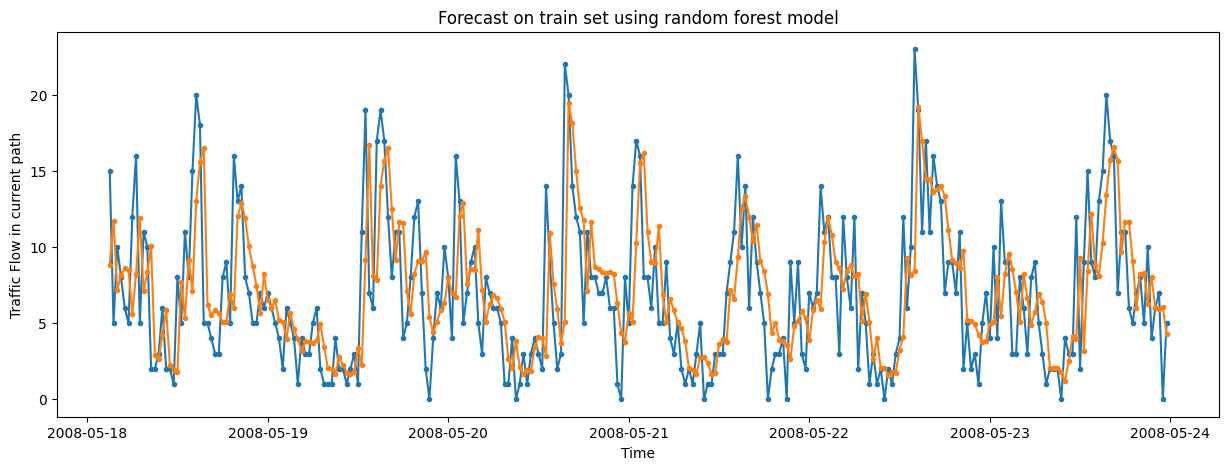

time: 3.34 s (started: 2023-08-11 11:35:58 +00:00)


In [76]:
# predict on the trainning set using random forest
y_pred_train_rf = best_model.predict(X_train)

# add information in the trainning set
train_predictions = pd.DataFrame(index=pd.to_datetime(train['Time Column']))
train_predictions.insert(0,'Train Actual',y_train['Traffic Flow 1(t)'].values)
train_predictions.insert(1,'Train Predicted',y_pred_train_rf)
train_predictions.insert(2,'Path',X_train['Path'].values)

# plot an example of the train-predictions
plt.figure(figsize=(15,5))
plt.plot(train_predictions[train_predictions['Path']==0][['Train Actual','Train Predicted']],".-")
plt.xlabel('Time')
plt.ylabel('Traffic Flow in current path')
plt.title('Forecast on train set using random forest model')
plt.show()

##### Step 7d: Evalueate the random forest regressor

In [77]:
# calculate the MAE
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print("MAE: ", mae_rf)

# calculate the RMSE
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
print("RMSE: ", rmse_rf)

MAE:  1.7841170893424583
RMSE:  2.8762997828365258
time: 9.63 ms (started: 2023-08-11 11:36:01 +00:00)


#### Step 8: Train an Encoder-Decoder model
This is the fourth model that we are using, in order to forecast the traffic flow.

##### Step 8a: Initialize and compile the Encoder-Decoder model

In [78]:
# add necessary imports
from keras import layers

time: 332 µs (started: 2023-08-11 11:36:01 +00:00)


In [79]:
# convert train and test set to infinite datasets for faster training
BATCH_SIZE = 1
BUFFER_SIZE = 1000

train_univariate = tf.data.Dataset.from_tensor_slices((trainX, trainY))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((testX, testY))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

time: 172 ms (started: 2023-08-11 11:36:01 +00:00)


In [80]:
### DEFINE THE ENCODER DECODER MODEL ###

# encoder part
enco_deco = Sequential()
enco_deco.add(LSTM(100, input_shape=(1, trainX.shape[2]), return_sequences=True))
enco_deco.add(Dropout(0.2))  # Add dropout to the first LSTM layer
enco_deco.add(LSTM(units=50, return_sequences=True))
enco_deco.add(Dropout(0.2))  # Add dropout to the second LSTM layer
enco_deco.add(LSTM(units=15))

# feature vector
enco_deco.add(layers.RepeatVector(1))

# decoder part
enco_deco.add(LSTM(units=100, return_sequences=True))
enco_deco.add(LSTM(units=50, return_sequences=True))
enco_deco.add(TimeDistributed(layers.Dense(units=1)))

time: 1.66 s (started: 2023-08-11 11:36:01 +00:00)


Similar to the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [81]:
#compile the encoder decoder model using adam optiizer
enco_deco.compile(optimizer='adam', loss='mse')

time: 12 ms (started: 2023-08-11 11:36:03 +00:00)


##### Step 8b: Train the model and make predictions

In [82]:
# train the enco-deco model
history = enco_deco.fit(train_univariate,
                        epochs=50,
                        steps_per_epoch=len(trainX)//100,
                        validation_data=val_univariate,
                        validation_steps=len(testX)//100,
                        verbose=1,
                        callbacks=[early_stopping])

Epoch 1/50
2820/2820 [==============================] - 50s 13ms/step - loss: 0.0041 - val_loss: 0.0070
Epoch 2/50
2820/2820 [==============================] - 36s 13ms/step - loss: 0.0042 - val_loss: 0.0067
Epoch 3/50
2820/2820 [==============================] - 35s 12ms/step - loss: 0.0020 - val_loss: 0.0053
Epoch 4/50
2820/2820 [==============================] - 37s 13ms/step - loss: 0.0025 - val_loss: 0.0052
Epoch 5/50
2820/2820 [==============================] - 36s 13ms/step - loss: 0.0014 - val_loss: 0.0058
Epoch 6/50
2820/2820 [==============================] - 36s 13ms/step - loss: 0.0023 - val_loss: 0.0066
Epoch 7/50
2820/2820 [==============================] - 36s 13ms/step - loss: 0.0033 - val_loss: 0.0083
Epoch 8/50
2820/2820 [==============================] - 35s 12ms/step - loss: 0.0025 - val_loss: 0.0059
Epoch 9/50
2820/2820 [==============================] - 36s 13ms/step - loss: 0.0016 - val_loss: 0.0061
Epoch 10/50
2820/2820 [==============================] - 36s 13m

In [83]:
# make predictions using Encoder-Decoder model
predicted_enco_deco = enco_deco.predict(testX)
predicted_enco_deco = scaler.inverse_transform(predicted_enco_deco.reshape(-1, 1))

1313/1313 [==============================] - 8s 4ms/step
time: 12.6 s (started: 2023-08-11 11:44:40 +00:00)


##### Step 8c: Evaluate the model

In [84]:
# calculate MAE of Encoder - Decoder model
mae_enco_deco = mean_absolute_error(y_test, predicted_enco_deco)

# calculate RMSE Encoder - Decoder model
rmse_enco_deco = mean_squared_error(y_test, predicted_enco_deco, squared=False)

print("MAE:", mae_enco_deco)
print("RMSE:", rmse_enco_deco)

MAE: 2.6674214443053517
RMSE: 3.607307729214188
time: 12.4 ms (started: 2023-08-11 11:44:52 +00:00)


Plot train loss vs. validation loss

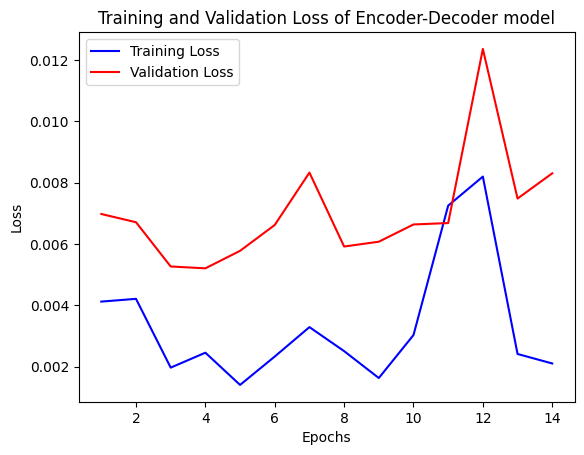

time: 385 ms (started: 2023-08-11 11:44:52 +00:00)


In [85]:
# get the train loss and validation loss values and plot them in the same graph
loss = history.history['loss']
val_loss = history.history['val_loss']

# plot the loss and validation loss
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss of Encoder-Decoder model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Forecast on train set using Encoder-Decoder model

8813/8813 [==============================] - 44s 5ms/step


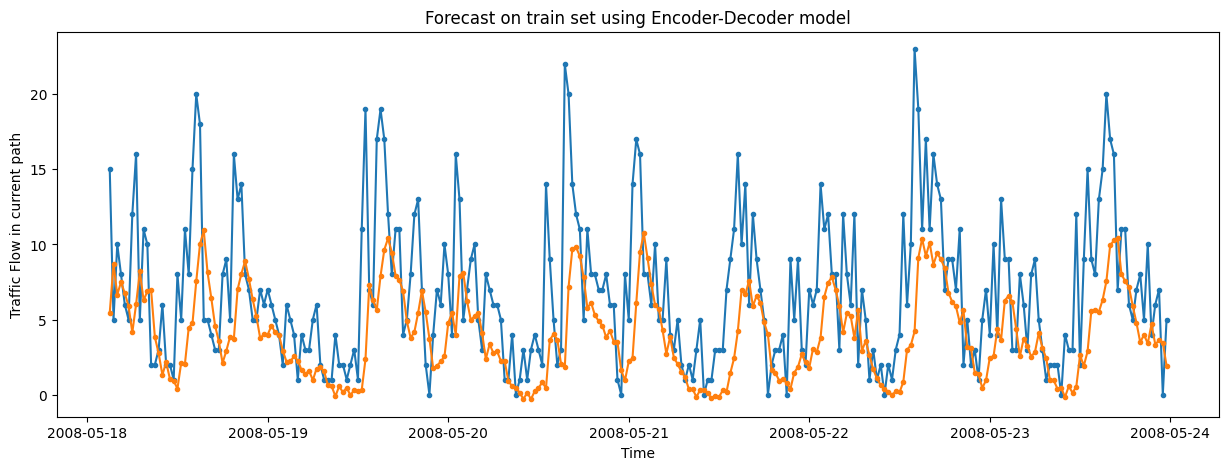

time: 1min 22s (started: 2023-08-11 11:44:53 +00:00)


In [86]:
# predict on the trainning set
y_pred_train_enco_deco = enco_deco.predict(trainX)
y_pred_train_enco_deco = scaler.inverse_transform(y_pred_train_enco_deco.reshape(-1, 1))

# add information in the trainning set
train_predictions = pd.DataFrame(index=pd.to_datetime(train['Time Column']))
train_predictions.insert(0,'Train Actual',y_train['Traffic Flow 1(t)'].values)
train_predictions.insert(1,'Train Predicted',y_pred_train_enco_deco)
train_predictions.insert(2,'Path',X_train['Path'].values)

# plot an example of the train-predictions
plt.figure(figsize=(15,5))
plt.plot(train_predictions[train_predictions['Path']==0][['Train Actual','Train Predicted']],".-")
plt.xlabel('Time')
plt.ylabel('Traffic Flow in current path')
plt.title('Forecast on train set using Encoder-Decoder model')
plt.show()

#### Step 9: Add predictions of the four models to the same dataframe

In [87]:
# store predictions of XGBoost model to a dataframe
total_predictions['Predicted XGBoost'] = y_pred_xgboost

time: 1.6 ms (started: 2023-08-11 11:46:15 +00:00)


In [88]:
# store predictions of LSTM model to a dataframe
total_predictions['Predicted LSTM'] = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

time: 2.24 ms (started: 2023-08-11 11:46:15 +00:00)


In [89]:
# add predictions of Random Forest model
total_predictions['Predicted Random Forest'] = y_pred_rf

time: 1.67 ms (started: 2023-08-11 11:46:15 +00:00)


In [90]:
# add predictions of Encoder-Decoder model
total_predictions['Predicted Encoder Decoder Model'] = predicted_enco_deco

time: 1.84 ms (started: 2023-08-11 11:46:15 +00:00)


In [91]:
# print dataframe with predictions
total_predictions

,Actual,Path,Predicted XGBoost,Predicted LSTM,Predicted Random Forest,Predicted Encoder Decoder Model
Time Column,,,,,,
2008-05-24 03:00:00,4.0,0,7.477365,515.255188,8.348223,11.526825
2008-05-24 03:30:00,7.0,0,6.383580,401.483429,6.586001,10.205637
2008-05-24 04:00:00,3.0,0,5.999142,424.270203,6.526145,10.124949
2008-05-24 04:30:00,9.0,0,5.208226,357.087555,5.825033,8.775290
2008-05-24 05:00:00,7.0,0,6.004172,425.016296,5.884103,10.121116
...,...,...,...,...,...,...
2008-05-24 21:30:00,0.0,999,0.489037,39.279850,0.450406,1.941061
2008-05-24 22:00:00,0.0,999,0.350342,22.927992,0.450406,1.967983
2008-05-24 22:30:00,1.0,999,0.337248,24.287071,0.450406,2.190145


time: 23.7 ms (started: 2023-08-11 11:46:15 +00:00)


#### Step 10: Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [92]:
# create dataframe with scores
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}
new_row2 = {'Model': 'Random Forest', 'RMSE Score': rmse_rf, 'MAE Score': mae_rf}
new_row3 = {'Model': 'Encoder Decoder', 'RMSE Score': rmse_enco_deco, 'MAE Score': mae_enco_deco}

# add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)
scores = scores.append(new_row2, ignore_index=True)
scores = scores.append(new_row3, ignore_index=True)

time: 19.1 ms (started: 2023-08-11 11:46:15 +00:00)


In [93]:
# print dataframe with all model scores
scores

,Model,RMSE Score,MAE Score
0,XGBoost,2.825479,1.747307
1,LSTM,2.935688,1.877717
2,Random Forest,2.876300,1.784117
3,Encoder Decoder,3.607308,2.667421


time: 11.6 ms (started: 2023-08-11 11:46:15 +00:00)


#### Step 11: Plot examples of actual vs Predicted for each of the models
In this part, we select a random path of the dataset and compare (for each model) the actual Traffic Flow values vs. the predicted ones

[]

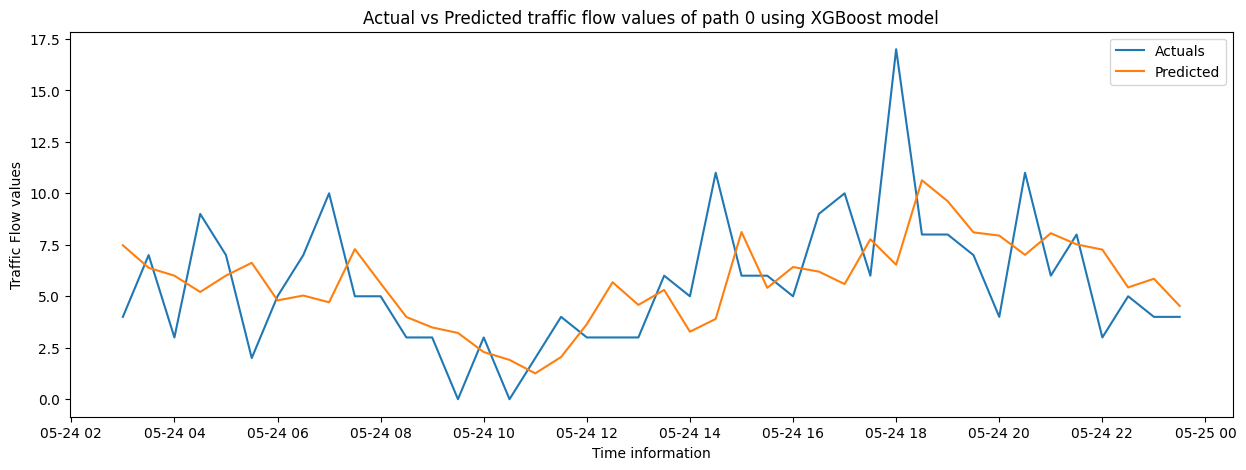

time: 626 ms (started: 2023-08-11 11:46:15 +00:00)


In [94]:
# plot results from XGBoost model
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==0]['Actual'],label='Actuals')
plt.plot(total_predictions[total_predictions['Path']==0]['Predicted XGBoost'],label='Predicted')
plt.xlabel("Time information")
plt.ylabel('Traffic Flow values')
plt.title('Actual vs Predicted traffic flow values of path 0 using XGBoost model')
plt.legend()
plt.plot()

[]

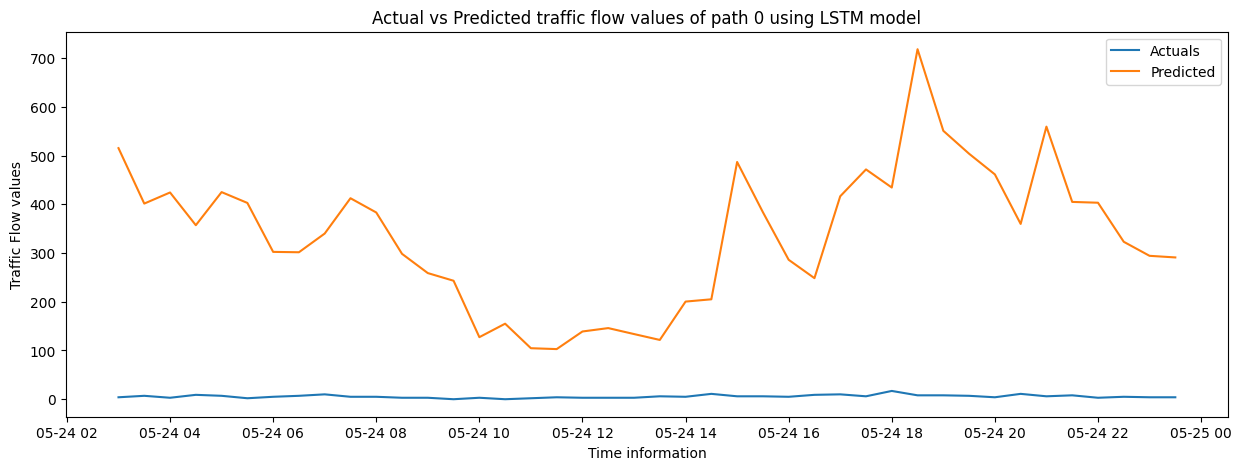

time: 575 ms (started: 2023-08-11 11:46:16 +00:00)


In [95]:
# plot results from LSTM model
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==0]['Actual'],label='Actuals')
plt.plot(total_predictions[total_predictions['Path']==0]['Predicted LSTM'],label='Predicted')
plt.xlabel("Time information")
plt.ylabel('Traffic Flow values')
plt.title('Actual vs Predicted traffic flow values of path 0 using LSTM model')
plt.legend()
plt.plot()

[]

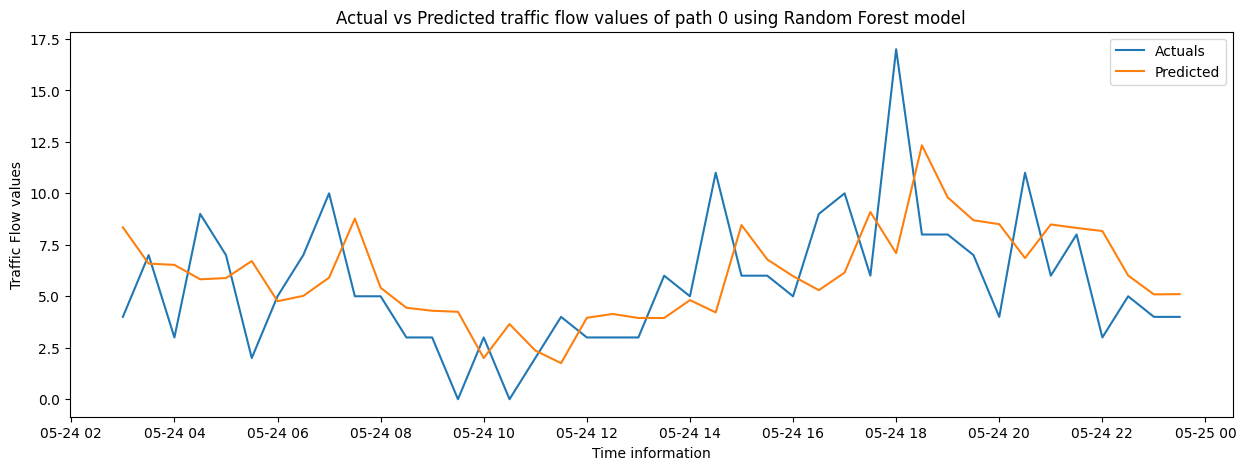

time: 370 ms (started: 2023-08-11 11:46:17 +00:00)


In [96]:
# plot results from Random Forest model
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==0]['Actual'],label='Actuals')
plt.plot(total_predictions[total_predictions['Path']==0]['Predicted Random Forest'],label='Predicted')
plt.xlabel("Time information")
plt.ylabel('Traffic Flow values')
plt.title('Actual vs Predicted traffic flow values of path 0 using Random Forest model')
plt.legend()
plt.plot()

[]

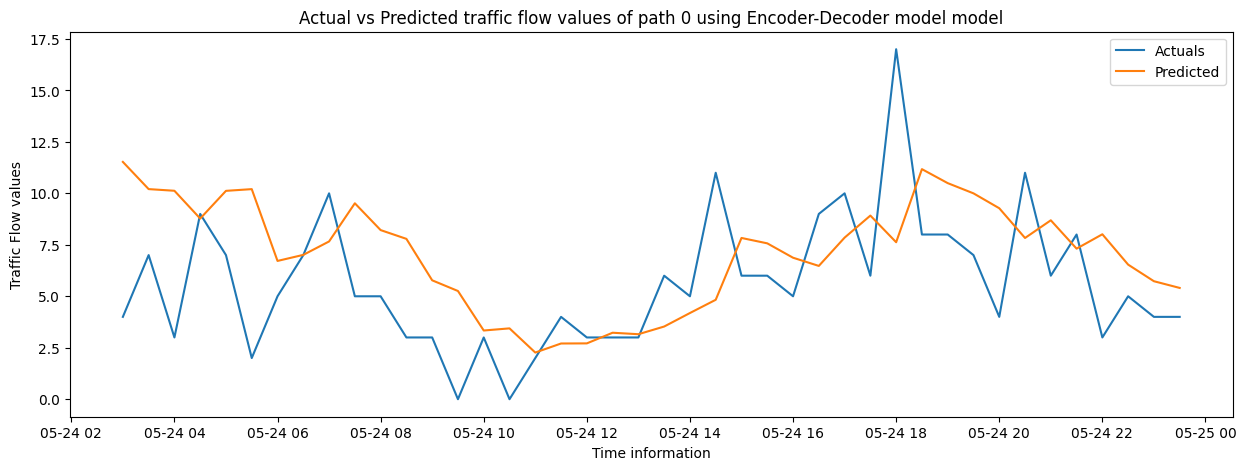

time: 414 ms (started: 2023-08-11 11:46:17 +00:00)


In [97]:
# plot results from Encoder-Decoder model
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==0]['Actual'],label='Actuals')
plt.plot(total_predictions[total_predictions['Path']==0]['Predicted Encoder Decoder Model'],label='Predicted')
plt.xlabel("Time information")
plt.ylabel('Traffic Flow values')
plt.title('Actual vs Predicted traffic flow values of path 0 using Encoder-Decoder model model')
plt.legend()
plt.plot()

#### Step 12: Make visualizations on actual vs predicted traffic flow data
Use best model's predictions from total_predictions dataframe and plot the residuals between the actual traffic flow values and predicted ones.

The graph to be created will contain the sum of traffic flow per timestamp, as done before in the visualization step.

In [98]:
# groupe dataframe by timestamp
grouped = total_predictions.groupby(total_predictions.index).sum()

# add results to dataframe
grouped = pd.DataFrame(grouped,index=grouped.index)

# drop path column, as it is useless in this step
grouped.drop('Path', axis=1, inplace=True)

time: 16.9 ms (started: 2023-08-11 11:46:17 +00:00)


##### Decide which model's predicted values will be used, based on the best RMSE score

In [99]:
# find the model with the best RMSE score (has the lowest RMSE value)
index = scores[['RMSE Score']].idxmin()

time: 3.97 ms (started: 2023-08-11 11:46:17 +00:00)


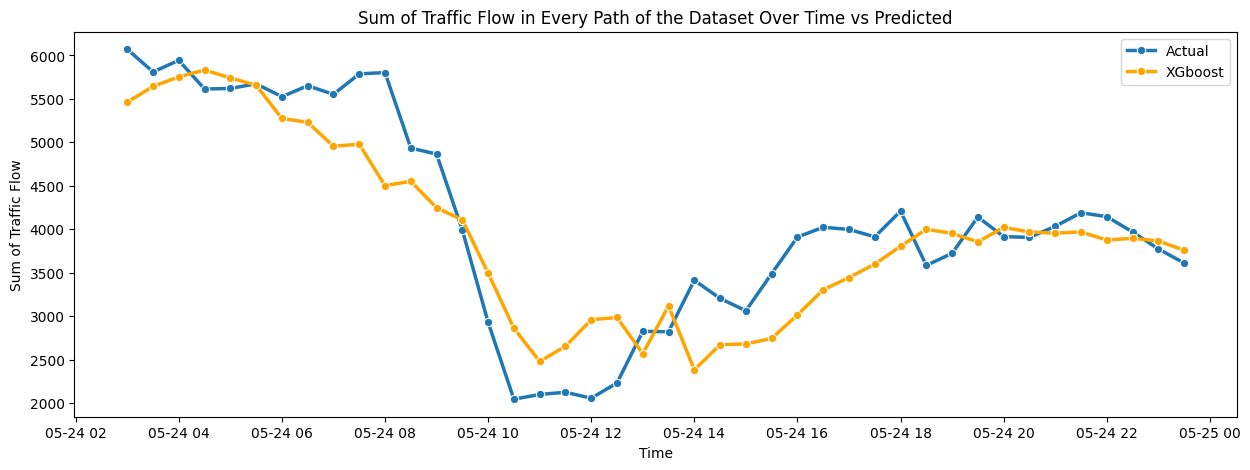

time: 398 ms (started: 2023-08-11 11:46:18 +00:00)


In [100]:
if (scores.iloc[index]['Model'][0] == 'XGBoost'):
    # create a plot to view the results
    plt.figure(figsize=(15,5))
    sns.lineplot(grouped,x=grouped.index,y='Actual',marker='o',linewidth=2.5,label='Actual')
    sns.lineplot(grouped,x=grouped.index,y='Predicted XGBoost',marker='o',linewidth=2.5, color='orange',label='XGboost')
    plt.xlabel('Time')
    plt.ylabel('Sum of Traffic Flow')
    plt.title('Sum of Traffic Flow in Every Path of the Dataset Over Time vs Predicted')
    plt.show()

elif (scores.iloc[index]['Model'][0] == 'LSTM'):
      # create a plot to view the results
      plt.figure(figsize=(15,5))
      sns.lineplot(grouped,x=grouped.index,y='Actual',marker='o',linewidth=2.5,label='Actual')
      sns.lineplot(grouped,x=grouped.index,y='Predicted XGBoost',marker='o',linewidth=2.5, color='orange',label='XGboost')
      plt.xlabel('Time')
      plt.ylabel('Sum of Traffic Flow')
      plt.title('Sum of Traffic Flow in Every Path of the Dataset Over Time vs Predicted')
      plt.show()

elif (scores.iloc[index]['Model'][0] == 'Random Forest'):
    # create a plot to view the results
      plt.figure(figsize=(15,5))
      sns.lineplot(grouped,x=grouped.index,y='Actual',marker='o',linewidth=2.5,label='Actual')
      sns.lineplot(grouped,x=grouped.index,y='Predicted XGBoost',marker='o',linewidth=2.5, color='orange',label='XGboost')
      plt.xlabel('Time')
      plt.ylabel('Sum of Traffic Flow')
      plt.title('Sum of Traffic Flow in Every Path of the Dataset Over Time vs Predicted')
      plt.show()

elif (scores.iloc[index]['Model'][0] == 'Encoder Decoder'):
    # create a plot to view the results
      plt.figure(figsize=(15,5))
      sns.lineplot(grouped,x=grouped.index,y='Actual',marker='o',linewidth=2.5,label='Actual')
      sns.lineplot(grouped,x=grouped.index,y='Predicted XGBoost',marker='o',linewidth=2.5, color='orange',label='XGboost')
      plt.xlabel('Time')
      plt.ylabel('Sum of Traffic Flow')
      plt.title('Sum of Traffic Flow in Every Path of the Dataset Over Time vs Predicted')
      plt.show()